<a href="https://colab.research.google.com/github/Muntasir2179/pytorch-learnig/blob/transfer-learning/06_pytorch_transfer_learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# PyTorch transfer learning

What is transfer learning?
Transfer learning involves taking the parameters of what one model has learned on another dataset and applying to our own problem.

* Pretrained model = foundation models

In [1]:
import torch
import torchvision

print(torch.__version__) # want 1.12+
print(torchvision.__version__) # want 0.13+

2.1.0+cu118
0.16.0+cu118


In [2]:
# Continue with regular imports
import matplotlib.pyplot as plt
import torch
import torchvision

from torch import nn
from torchvision import transforms

# Try to get torchinfo, install it if it doesn't work
try:
    from torchinfo import summary
except:
    print("[INFO] Couldn't find torchinfo... installing it.")
    !pip install -q torchinfo
    from torchinfo import summary

# Try to import the going_modular directory, download it from GitHub if it doesn't work
try:
    from going_modular.going_modular import data_setup, engine
except:
    # Get the going_modular scripts
    print("[INFO] Couldn't find going_modular scripts... downloading them from GitHub.")
    !git clone https://github.com/mrdbourke/pytorch-deep-learning
    !mv pytorch-deep-learning/going_modular .
    !rm -rf pytorch-deep-learning
    from going_modular.going_modular import data_setup, engine

[INFO] Couldn't find torchinfo... installing it.
[INFO] Couldn't find going_modular scripts... downloading them from GitHub.
Cloning into 'pytorch-deep-learning'...
remote: Enumerating objects: 4036, done.
remote: Counting objects: 100% (1224/1224), done.
remote: Compressing objects: 100% (225/225), done.
remote: Total 4036 (delta 1068), reused 1078 (delta 996), pack-reused 2812
Receiving objects: 100% (4036/4036), 651.02 MiB | 16.46 MiB/s, done.
Resolving deltas: 100% (2361/2361), done.
Updating files: 100% (248/248), done.


In [3]:
# set up device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [4]:
!nvidia-smi

Sun Dec  3 16:32:11 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   52C    P8     9W /  70W |      3MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 1.0 Get the data

We need our pizza, steak and sushi data to build a transfer learning model on.

In [5]:
import os
import zipfile
from pathlib import Path
import requests

# setting up the data paths
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

if image_path.is_dir():
  print(f"{image_path} directory exists, skepping re-download.")
else:
  print(f"Did not find {image_path}, downloading it...")
  image_path.mkdir(parents=True, exist_ok=True)

  # download data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as file:
    request = requests.get(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza_steak_sushi data...")
    file.write(request.content)

  # unzip the data
  with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
    print("Unzipping pizza, steak, sushi data...")
    zip_ref.extractall(image_path)

  # removing the pizza_steak_sushi.zip file
  os.remove(data_path / "pizza_steak_sushi.zip")

Did not find data/pizza_steak_sushi, downloading it...
Unzipping pizza, steak, sushi data...


In [6]:
# setting up the directory paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

# 2.0 Create Datasets and DataLoaders

We are going to use `data_setup.py` and `create_dataloaders()` function that we have written in `Going Modular` section.

There's one thing we have to think about when loading: how to **transform** it?
Ans with `torchvision` there's two ways to do this:

1. Manually created transforms - What transforms we want our data to go through.
2. Automatically created transforms - The transforms that is defined for the model that we want to use.

Important point: When using a pretrained model, it's important that the data (including the custom data) that you pass through it is **transformed** in the same way that the data the model was trained on.

In [7]:
from going_modular.going_modular import data_setup

## 2.1 Createing a transform for `torchvision.models` (manual creation)

`torchvision.models` contains pretrained models (models ready for transfer learning) right within `torchvision`.

While using transfer learning, we need to keep the data distribution same as the data which is used to train the pretrained model that we want to use.

>All pre-trained models expect input images normalized in the same way, i.e. mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W are expected to be at least 224. The images have to be loaded in to a range of [0, 1] and then normalized using mean = [0.485, 0.456, 0.406] and std = [0.229, 0.224, 0.225]. You can use the following transform to normalize:

```python
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
```

In [8]:
from torchvision import transforms
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

manual_transforms = transforms.Compose([
    transforms.Resize(size=(224, 224)),  # resizing the image into (224, 224)
    transforms.ToTensor(),  # getting the values between (1, 0)
    normalize  # make sure images have the same distribution as ImageNet (where our pretrained model has been trained)
])

In [9]:
from going_modular.going_modular import data_setup

tran_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                              test_dir = test_dir,
                                                                              transform = manual_transforms,
                                                                              batch_size = 32)
tran_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78ee0e2b1240>,
 ['pizza', 'steak', 'sushi'])

## 2.2 Creating a transform for `torchvision.models` (auto creation)

As of `torchvision` v0.13+ there is now support for automatic data transform creation based on the pretrained model weights we are using.

In [10]:
weights = torchvision.models.RegNet_X_3_2GF_Weights.DEFAULT # DEFAULT = best available weights
weights

RegNet_X_3_2GF_Weights.IMAGENET1K_V2

In [11]:
# get the transfoms used to create our pretrained weights
auto_transforms = weights.transforms()
auto_transforms

ImageClassification(
    crop_size=[224]
    resize_size=[232]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BILINEAR
)

In [12]:
# creating DataLoaders using automatic transforms
train_dataloader, test_dataloader, class_names = data_setup.create_dataloaders(train_dir = train_dir,
                                                                               test_dir = test_dir,
                                                                               transform = auto_transforms,
                                                                               batch_size = 32)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x78ee0e2b2f80>,
 ['pizza', 'steak', 'sushi'])

# 3.0 Getting a pretrained model

There are various places to get pretrained models, such as:
1. PyTorch domain libraries.
2. Libraries like `timm` (torch image models)
3. HuggingFace Hub (for plenty different models)
4. Paperswithcode (for models across different problem space/domains)

## 3.1 Which pretrained model should we use?

*Experiment, experiment, experiment*

The whole idea of transfer learning: take an already well-performing model from a problem space similar to your own and then customize to our own problem.

There are three things to consider:
1. Speed - How fast does it run.
2. Size - How big the model is?
3. Performance - How well does it go on our choosen problem (e.g. how well does it classify food images? for FoodVision Mini)?

Where does the model live?

Is it on device? (Like a self-driving car)

Or does it live on a server?

Looking at https://pytorch.org/vision/stable/models.html#table-of-all-available-classification-weights

Which model should we choose?

For our case (deploying FoodVision Mini on a mobile device), it looks like REGNET_X_3_2GF is one of our best options in terms of performance vs size.

However, in light of The Bitter Lesson, if we had infinite compute, we'd likely pick the bigest model + most parameters + most general we could - http://www.incompleteideas.net/IncIdeas/BitterLesson.html

## 3.2 Setting up a pretrained model

We want to create an instance of REGNET_X_3_2GF - https://pytorch.org/vision/stable/models/generated/torchvision.models.regnet_x_3_2gf.html#torchvision.models.RegNet_X_3_2GF_Weights

In [21]:
# old method of creating a pretrained model (prior to torchvision v0.13)
# model = torchvision.models.regnet_x_3_2gf(pretrained=True)
# model

# new method of creating a pretrained model (torchvision v0.13+)
weights = torchvision.models.RegNet_X_3_2GF_Weights.DEFAULT
model = torchvision.models.regnet_x_3_2gf(weights = weights).to(device)
model

RegNet(
  (stem): SimpleStemIN(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (trunk_output): Sequential(
    (block1): AnyStage(
      (block1-0): ResBottleneckBlock(
        (proj): Conv2dNormActivation(
          (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(2, 2), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        (f): BottleneckTransform(
          (a): Conv2dNormActivation(
            (0): Conv2d(32, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU(inplace=True)
          )
          (b): Conv2dNormActivation(
            (0): Conv2d(96, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=2, bias=False)
            

In [22]:
# let's check how many hidden units are there in the fully connected layer
# it looks like the model is trained for 1000 image classes
model.fc

Linear(in_features=1008, out_features=1000, bias=True)

## 3.3 Freezing the base model and changing the output layer to suit our needs

With a feature extractor model, typically we will "freeze" the base layers of a pretrained/foundation model and update the output layer to suit our own problem.

In [23]:
# freezing the feature extractor layers / base layers
for param in model.parameters():
  param.requires_grad = False   # turning off the gradient tracking for learned parameters

In [30]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

num_features = model.fc.in_features  # getting the feature vector size
model.fc = nn.Linear(in_features=num_features,  # feature commig in
                     out_features=len(class_names)).to(device)  # updating the last layer for custom dataset

# making the last layer trainable
model.fc.requires_grad_(requires_grad=True)

Linear(in_features=1008, out_features=3, bias=True)

# 4.0 Training the model

In [31]:
# define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.001)

In [32]:
# importing train functions
from going_modular.going_modular import engine

# set manual seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# start the timer
from timeit import default_timer as timer
start_time = timer()

# training the model
results = engine.train(model = model,
                       train_dataloader = train_dataloader,
                       test_dataloader = test_dataloader,
                       loss_fn = loss_fn,
                       optimizer = optimizer,
                       device = device,
                       epochs = 6)

# end time
end_time = timer()

print(f"Total training time: {end_time - start_time: 0.3f}")

  0%|          | 0/6 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 1.0828 | train_acc: 0.4727 | test_loss: 1.0738 | test_acc: 0.4261
Epoch: 2 | train_loss: 0.9492 | train_acc: 0.5938 | test_loss: 0.9518 | test_acc: 0.6913
Epoch: 3 | train_loss: 0.7999 | train_acc: 0.8164 | test_loss: 0.8647 | test_acc: 0.7633
Epoch: 4 | train_loss: 0.7115 | train_acc: 0.7656 | test_loss: 0.7876 | test_acc: 0.8248
Epoch: 5 | train_loss: 0.6756 | train_acc: 0.7812 | test_loss: 0.7495 | test_acc: 0.7936
Epoch: 6 | train_loss: 0.6449 | train_acc: 0.7656 | test_loss: 0.7074 | test_acc: 0.8864
Total training time:  17.722


# 5.0 Evaluating model by ploting the loss curves

[INFO] Couldn't find helper_functions.py, downloading....


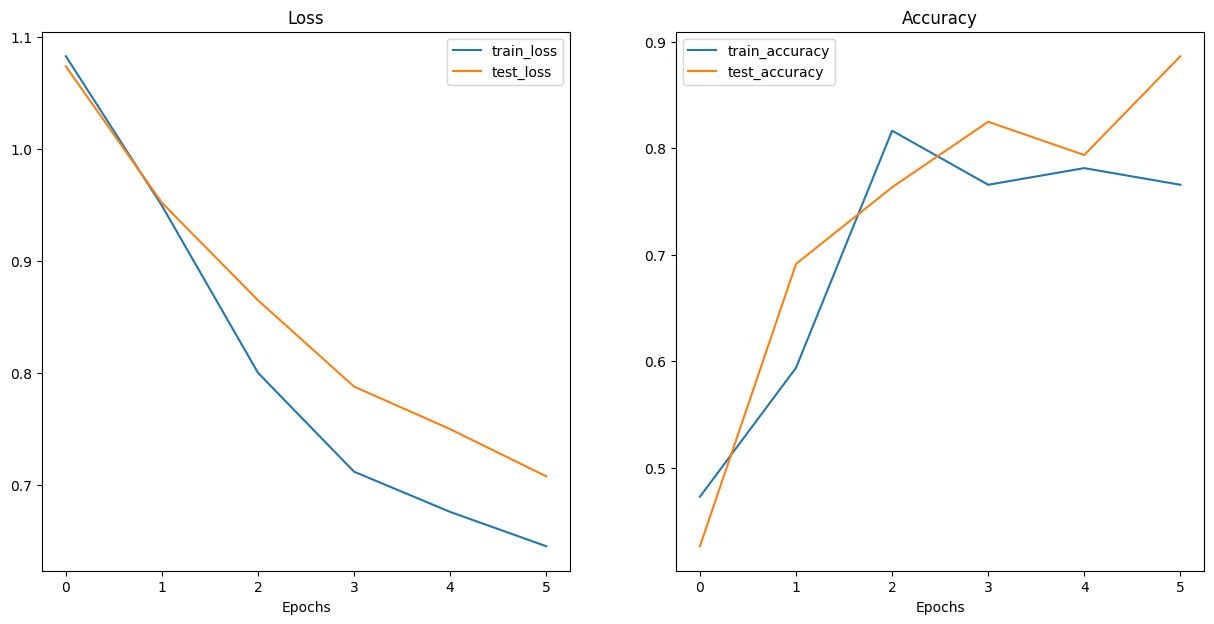

In [33]:
try:
  from helper_functions import plot_loss_curves
except:
  print("[INFO] Couldn't find helper_functions.py, downloading....")
  with open("helper_functions.py", "wb") as f:
    import requests
    response = requests.get(url="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/helper_functions.py")
    f.write(response.content)
  f.close()
  from helper_functions import plot_loss_curves

# plot the loss curves
plot_loss_curves(results)

# 6.0 Making prediction on custom image

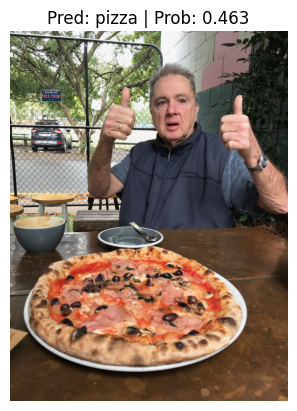

In [35]:
from going_modular.going_modular import predictions

predictions.pred_and_plot_image(model = model,
                                class_names = class_names,
                                image_path = "/content/04-pizza-dad.jpeg",
                                image_size = (224, 224),
                                transform = auto_transforms,
                                device = device)